# Definiëren van hulpfuncties


Importeer libraries:

In [2]:
import numpy as np
from numpy import sin, cos
import scipy
from math import log
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time as clock
import asyncio
from matplotlib import animation
from IPython.display import Video
import time as system_time
import seaborn as sns

Definieer de constanten / configuratie:

In [3]:
G = 9.81
sns.set_theme()

Definieer de afgeleiden als een stelsel van 4 differentiaalvergelijkingen van de eerste order:

In [4]:
def derivs(state, t, m1, m2, l1, l2):
    dydx = np.zeros_like(state)
    
    dydx[0] = state[1]

    delta = state[2] - state[0]
    den1 = (m1 + m2) * l1 - m2 * l1 * cos(delta) * cos(delta)
    dydx[1] = ((m2 * l1 * state[1] * state[1] * sin(delta) * cos(delta)
                + m2 * G * sin(state[2]) * cos(delta)
                + m2 * l2 * state[3] * state[3] * sin(delta)
                - (m1 + m2) * G * sin(state[0]))
               / den1)

    dydx[2] = state[3]

    den2 = (l2 / l1) * den1
    dydx[3] = ((- m2 * l2 * state[3] * state[3] * sin(delta) * cos(delta)
                + (m1 + m2) * G * sin(state[0]) * cos(delta)
                - (m1 + m2) * l1 * state[1] * state[1] * sin(delta)
                - (m1 + m2) * G * sin(state[2]))
               / den2)
    
    return dydx

Definieer een functie voor het genereren van data vanuit de initiële waarden:

In [5]:
def get_resulting_array(t, theta1, theta1_dot, theta2, theta2_dot, m1, m2, l1, l2):
    state = [theta1, theta1_dot, theta2, theta2_dot]
    results = scipy.integrate.odeint(lambda S, t : derivs(S, t, m1, m2, l1, l2), state, t)
    return results

Definieer een functie voor het omzetten van data naar cartesische coördinaten:

In [6]:
def get_coordinates(results, l1, l2):
    theta1 = results[:,0]
    theta2 = results[:,2]
    
    return (
        l1*np.sin(theta1),
        -l1*np.cos(theta1),
        l1*np.sin(theta1) + l2*np.sin(theta2),
        -l1*np.cos(theta1) - l2*np.cos(theta2)
    )

Definieer en functie voor de afstanden tussen twee slingers:

In [7]:
def get_distance(results1, results2):
    return np.abs(np.subtract(results1, results2))

Definieer een functie om de Lyapunov exponenten te berekenen uit twee resultaten:

In [8]:
def get_lyapunov_values(t, differences):
    thetha1_differences = differences[:, 0]
    lyapunov = []
    
    for index, time in enumerate(t):
        exponent = (1 / time) * log(thetha1_differences[index] / thetha1_differences[0])
        lyapunov.append(exponent)
        
    return lyapunov

Maak een class om te helpen bij het loggen van laadtijden:

In [9]:
class TimeLogger:
    
    def __init__(self, total_frames, name):
        self.total_frames = total_frames
        self.name = name
        self.current_frame = 0
        self.last_result = 0
        self.gain = 0.1
        self.start_time = system_time.time()
        
    def update(self):
        now = system_time.time()
        dt = now - self.start_time
        self.start_time = now
        
        if (self.last_result == 0):
            self.last_result = dt
                
        filtered_dt = self.gain * dt + (1 - self.gain) * self.last_result
        self.last_result = filtered_dt
            
        frames_remaining = self.total_frames - self.current_frame
        time_remaining = frames_remaining * filtered_dt
        time_remaining_formatted = clock.strftime("%H:%M:%S", clock.gmtime(time_remaining))
        
        self.current_frame += 1
        print(str(self.name) + " completion: " + (str(round(self.current_frame / self.total_frames * 1000) / 10)) + "%, time remaining: " + str(time_remaining_formatted), end='\r')

# Grafieken

Regressie van twee slingers:

C:\Users\Kevin\AppData\Local\Temp\ipykernel_8420\1429239187.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  exponent = (1 / time) * log(thetha1_differences[index] / thetha1_differences[0])
C:\Users\Kevin\AppData\Local\Temp\ipykernel_8420\1429239187.py:6: RuntimeWarning: invalid value encountered in scalar multiply
  exponent = (1 / time) * log(thetha1_differences[index] / thetha1_differences[0])


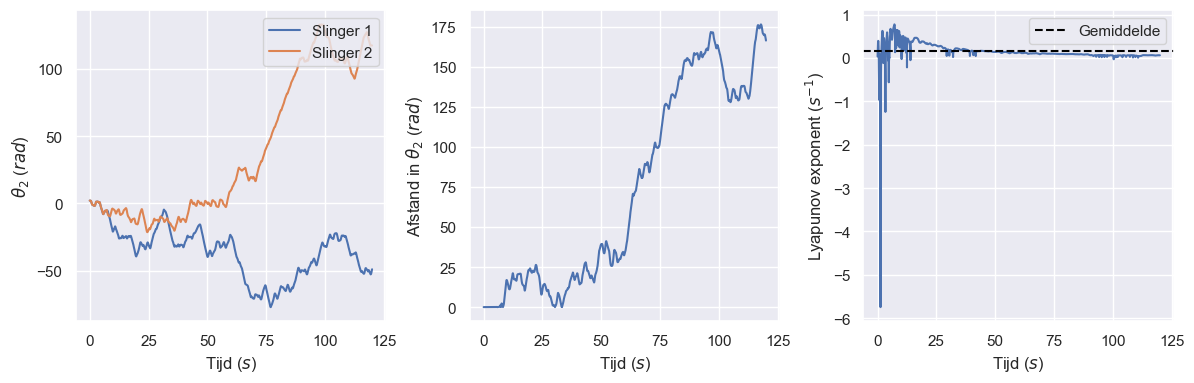

In [31]:
# Configuratie
t_end = 120
FPS = 60
t = np.arange(0, t_end, 1/FPS)
save_name = "output/regression.png"

# Slingers configuratie
l1 = 1
l2 = 1
m1 = 1
m2 = 1
theta1 = 2
theta2 = 2
dtheta = 0.005

# Bereken resulterende data
results1 = get_resulting_array(t, theta1 - dtheta / 2, 0, theta2 - dtheta / 2, 0, m1, m2, l1, l2)
results2 = get_resulting_array(t, theta1 + dtheta / 2, 0, theta2 + dtheta / 2, 0, m1, m2, l1, l2)

distances = get_distance(results1, results2)
lyapunov_values = get_lyapunov_values(t, distances)

# Maak dataframes aan
pendulums_dataframe = pd.DataFrame({"Slinger 1": results1[:, 2], "Slinger 2": results2[:, 2]}, t)
distance_dataframe = pd.DataFrame(distances[:, 2], t)
lyapunov_dataframe = pd.DataFrame(lyapunov_values, t)

# Maak lijnen voor grafiek aan
fig, axs = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4, 4]))

# Figuur 1: Theta2 tegen tijd
plot1 = sns.lineplot(pendulums_dataframe, ax=axs[0], dashes = False)
plot1.set(xlabel=r"Tijd ($s$)", ylabel=r"$\theta_2$ ($rad$)")
sns.move_legend(plot1, "upper right")

plot2 = sns.lineplot(distance_dataframe, ax=axs[1], legend=False)
plot2.set(xlabel=r"Tijd ($s$)", ylabel=r"Afstand in $\theta_2$ ($rad$)")

plot3 = sns.lineplot(lyapunov_dataframe, ax=axs[2], legend=False)
plot3.set(xlabel=r"Tijd ($s$)", ylabel=r"Lyapunov exponent ($s^{-1}$)")

axs[2].axhline(lyapunov_dataframe[0].mean(), label="Gemiddelde", color="black", linestyle="--")
axs[2].legend()

fig.tight_layout()
plt.savefig(save_name)    

# Animaties

Één dubbele slinger:

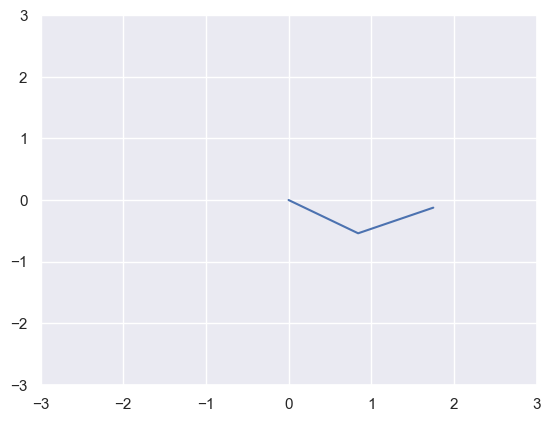

<Figure size 640x480 with 0 Axes>

In [48]:
t_end = 30
FPS = 30
t = np.arange(0, t_end, 1/FPS)
save_name = "output/doublePendulum.mp4"

l1 = 1
l2 = 1
m1 = 1
m2 = 1

results = get_resulting_array(t, 1, 0, 2, 0, m1, m2, l1, l2)

fig = plt.figure()
pendulum_line, = plt.plot([], [])

def animate(frame):
    x1, y1, x2, y2 = get_coordinates(results, l1, l2)
    pendulum_line.set_data([0, x1[frame], x2[frame]], [0, y1[frame], y2[frame]])

plt.xlim(-3, 3)
plt.ylim(-3, 3)
fig = plt.figure()
ani = animation.FuncAnimation(fig, animate, frames=len(results), interval=1000/FPS)

ani.save(save_name)
Video(save_name)

Regressie van twee slingers

In [ ]:
# Animatie configuratie
t_end = 12
FPS = 30
t = np.arange(0, t_end, 1/FPS)
trace_time = 1
save_name = "output/regression.mp4"

# Slingers configuratie
l1 = 2
l2 = 1
m1 = 2
m2 = 1
theta1 = 2
theta2 = 0
dtheta = 0.01

# Bereken resulterende data
results1 = get_resulting_array(t, theta1 - dtheta / 2, 0, theta2 - dtheta / 2, 0, m1, m2, l1, l2)
results2 = get_resulting_array(t, theta1 + dtheta / 2, 0, theta2 + dtheta / 2, 0, m1, m2, l1, l2)
x1_1, y1_1, x2_1, y2_1 = get_coordinates(results1, l1, l2)
x1_2, y1_2, x2_2, y2_2 = get_coordinates(results2, l1, l2)

distances = get_distance(results1, results2)
lyapunov_values = get_lyapunov_values(t, distances)

# Maak lijnen voor grafiek aan
fig = plt.figure()
ax1 = plt.subplot(2, 2, (1, 3))
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 4, sharex=ax2)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)
ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)

pendulum_line1, = ax1.plot([], [], color="b")
pendulum_line2, = ax1.plot([], [], color="r")
pendulum_trace_line1, = ax1.plot([], [], color="b", alpha=0.2)
pendulum_trace_line2, = ax1.plot([], [], color="r", alpha=0.2)

distance_line = ax2.plot(t, distances[:, 0])
distance_time_scroller = ax2.axvline(0)

lyapunov_line, = ax3.plot(t, lyapunov_values)
lyapunov_time_scroller = ax3.axvline(0)

timeLogger = TimeLogger(len(t), "Frame animation")

# Definieer de animatie functie
def animate(frame):
    trace_start_frame = np.clip(frame - trace_time * FPS, 0, len(t))
    
    pendulum_line1.set_data([0, x1_1[frame], x2_1[frame]], [0, y1_1[frame], y2_1[frame]])
    pendulum_line2.set_data([0, x1_2[frame], x2_2[frame]], [0, y1_2[frame], y2_2[frame]])
    
    pendulum_trace_line1.set_data(x2_1[trace_start_frame:frame], y2_1[trace_start_frame:frame])
    pendulum_trace_line2.set_data(x2_2[trace_start_frame:frame], y2_2[trace_start_frame:frame])
        
    distance_time_scroller.set_xdata(frame / FPS)
    lyapunov_time_scroller.set_xdata(frame / FPS)
    
    timeLogger.update()

# Maak een animatie, sla hem op en laat hem zien
ani = animation.FuncAnimation(fig, animate, frames=len(t), interval=1000/FPS)
ani.save(save_name)
Video(save_name)